# 1. 微调

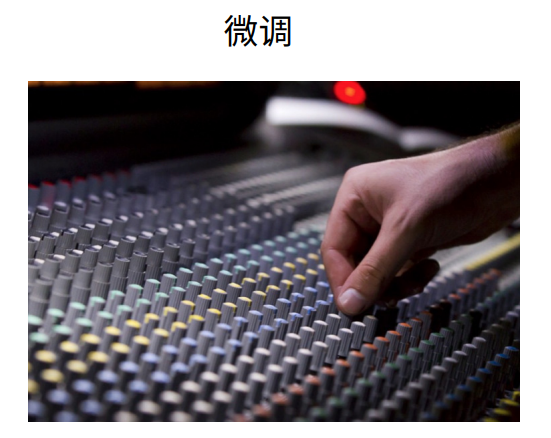

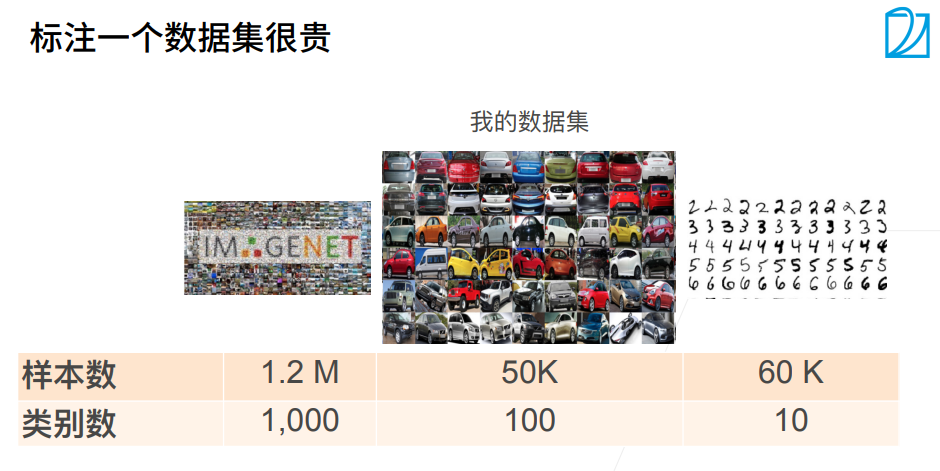

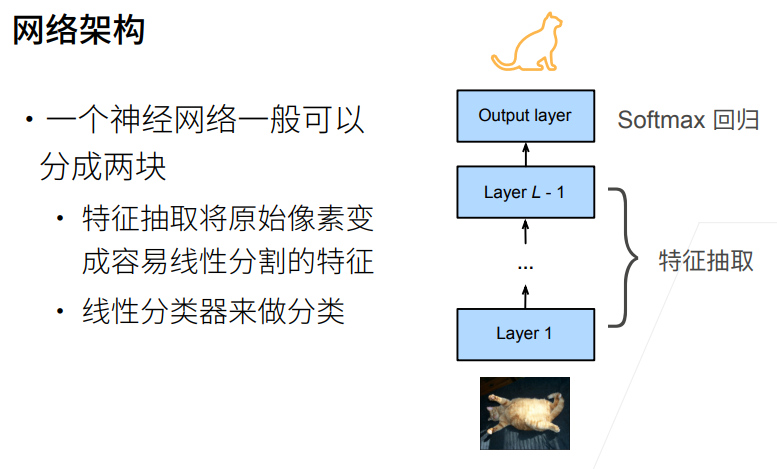

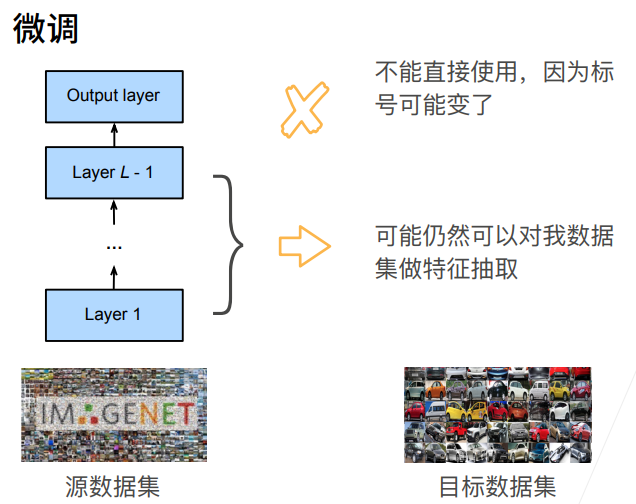

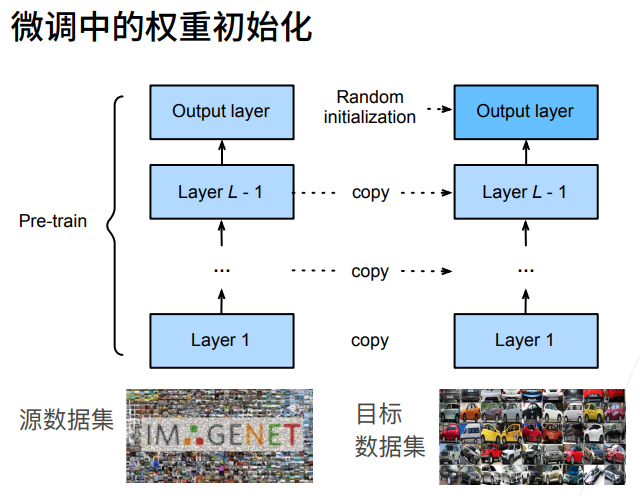

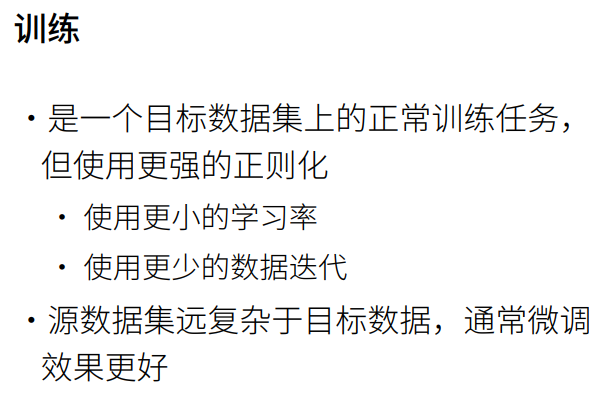

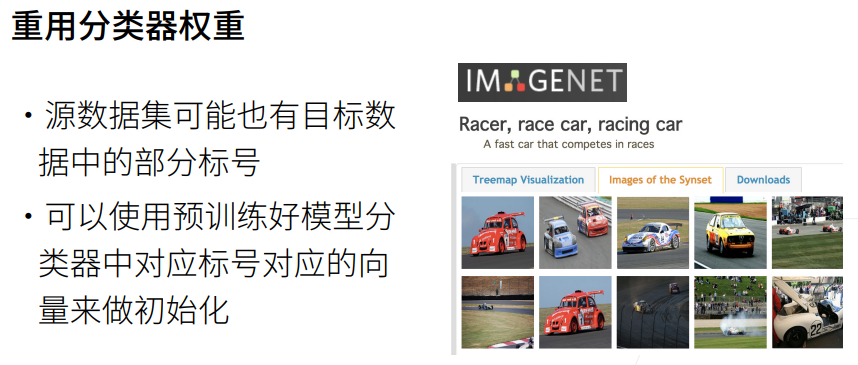

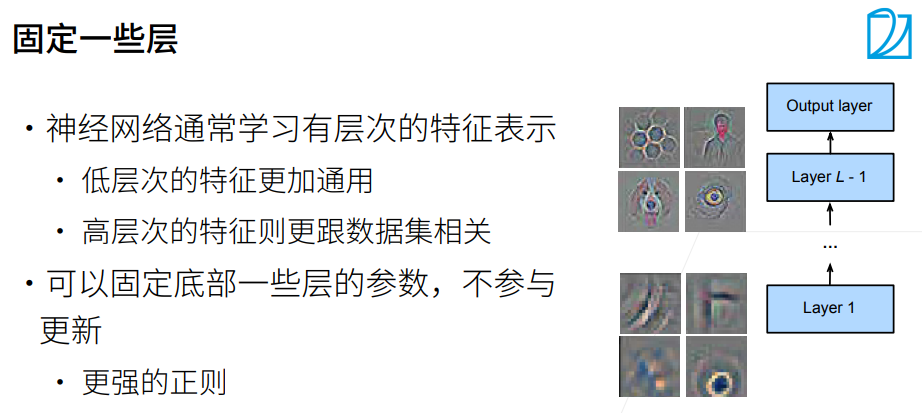

# 2. 总结

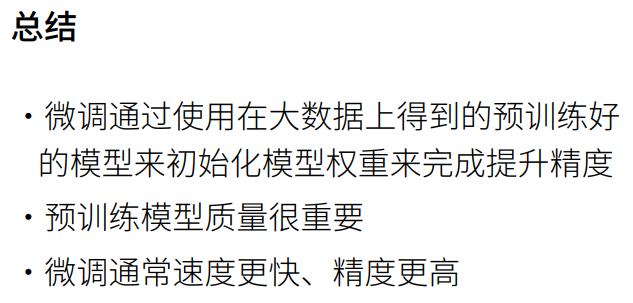

# 1. 微调

In [1]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip','fba480ffa8aa7e0febbb511d181409f899b9baa5')    
data_dir = d2l.download_extract('hotdog')

train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir,'train'))   
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir,'test'))

(<PIL.Image.Image image mode=RGB size=122x144 at 0x1F2CBDF9AC8>, 0)
<PIL.Image.Image image mode=RGB size=122x144 at 0x1F2CBDF9C18>


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

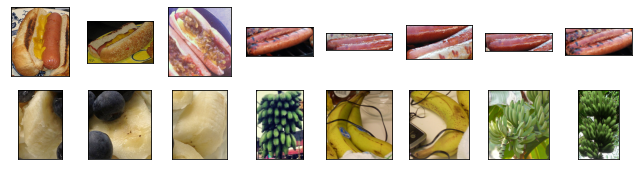

In [3]:
# 图片的大小和纵横比各有不同
hotdogs = [train_imgs[i][0] for i in range(8)]
print(train_imgs[0]) # 图片和标签，合为一个元组
print(train_imgs[0][0]) # 元组第一个元素为图片
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4)

In [4]:
# 数据增广
normalize = torchvision.transforms.Normalize([0.485,0.456,0.406],
                                            [0.229,0.224,0.225]) # 按该均值、方差做归一化  

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize ])  

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize ])

In [5]:
# 定义和初始化模型
pretrained_net = torchvision.models.resnet18(pretrained=True) # 把模型和在ImageNet上定义好的参数拿过来   
pretrained_net.fc # full connection全连接层，最后一层，查看最后一层的输入和输出结构  

Linear(in_features=512, out_features=1000, bias=True)

In [6]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features,2) # 最后一层修改为输出类别数为2   
nn.init.xavier_uniform_(finetune_net.fc.weight) # 只对最后一层的weight做随即初始化   

Parameter containing:
tensor([[ 0.0004, -0.0395, -0.0163,  ...,  0.0185, -0.0238,  0.0693],
        [ 0.0307,  0.0278,  0.0082,  ..., -0.0852,  0.0642, -0.0302]],
       requires_grad=True)

In [7]:
# 微调座位
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    train_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir,'train'),transform=train_augs),
        batch_size = batch_size,shuffle=True)
    test_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir,'test'),transform=test_augs),
        batch_size=batch_size)    
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        # 除了最后一层的learning rate外，用的是默认的learning rate
        # 最后一层的learning rate用的是十倍的learning rate
        params_lx = [
            param for name, param in net.named_parameters()
            if name not in ["fc.weight","fc.bias"] ]
        trainer = torch.optim.SGD([
            {'params': params_lx}, 
            {'params': net.fc.parameters(), 'lr': learning_rate * 10}],
            lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(),lr=learning_rate,weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)   

loss 0.163, train acc 0.932, test acc 0.935
265.9 examples/sec on [device(type='cuda', index=0)]


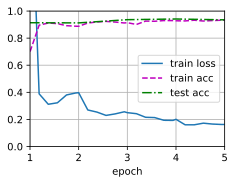

In [8]:
# 使用较小的学习率
train_fine_tuning(finetune_net,5e-5)

loss 0.349, train acc 0.847, test acc 0.806
422.1 examples/sec on [device(type='cuda', index=0)]


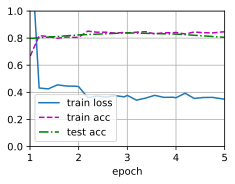

In [9]:
# 为了进行比较，所有模型参数初始化为随机值
scratch_net = torchvision.models.resnet18() # 这里没有pretrained=True，没有拿预训练的参数   
scratch_net.fc = nn.Linear(scratch_net.fc.in_features,2)
train_fine_tuning(scratch_net,5e-4,param_group=False) # param_group=False使得所有层的参数都为默认的学习率   